In [62]:
import warnings

import pandas

warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
base_d_results = pd.read_excel("datasets/Dynamic_BG_results.xlsx", "Dynamic_BG", header=None)

def gersdemo_prepare_results(results_df):
    results_df = results_df.T
    results_df = results_df.fillna(0)
    results_df.columns = results_df.iloc[0]
    results_df = results_df[1:]
    results_df.reset_index(drop=True, inplace=True)
    return results_df

def gersdemo_prod_results(results_df, clean=True, name_adj = ""):
    # Results setup. Done to create a cleaned dataframe that puts the columns as the attributes and years, and that changes all NA values to 0, since the model outputs no production as NA.
    if clean:
        results_df = gersdemo_prepare_results(results_df)
    
    # An output dataframe which includes the year and production for coal, gas, and oil. Done to allow for easier summation mathematics.
    output_df = pd.DataFrame(columns=["Year", name_adj + "Coal Prod", name_adj + "Gas Prod", name_adj + "Oil Prod"])
    
    # Finding the first numeric column in the dataset, then getting its location. This is done to ensure that, if a change was made to the dataframe, the code would still start at the first year of production XXXX.
    first_numeric_col = results_df.apply(pd.to_numeric, errors='coerce').notna().any().idxmax()
    first_col_index = results_df.columns.get_loc(first_numeric_col)
    years = results_df.columns[first_col_index:]
    
    coal_data = results_df[results_df['mineral'] == 'Coal']
    gas_data = results_df[results_df['mineral'] == 'Gas']
    oil_data = results_df[results_df['mineral'] == 'Oil']
    
    # Loops through each year in the total model years, creates a year dataframe, and then concats that onto the output dataframe. This is done to allow for easy summation per year, where each year is the sum of it and the previous years production.
    for i, year in enumerate(years):
        i_adj = i + first_col_index
        
        year_prod = pd.DataFrame.from_dict({
            "Year": [int(year)],
            name_adj + "Coal Prod": [coal_data.iloc[:, i_adj].sum()],
            name_adj + "Gas Prod": [gas_data.iloc[:, i_adj].sum()],
            name_adj + "Oil Prod": [oil_data.iloc[:, i_adj].sum()]
        })
        output_df = pd.concat([output_df, year_prod], ignore_index=True)
    
    return output_df

def gersdemo_summed_results(results_df):
    # Results setup. Done to create a cleaned dataframe that puts the columns as the attributes and years, and that changes all NA values to 0, since the model outputs no production as NA.
    results_df = gersdemo_prepare_results(results_df)
    
    # An output dataframe which includes the year and production for coal, gas, and oil. Done to allow for easier summation mathematics.
    output_df = pd.DataFrame(columns=["Year", "Coal Sum Prod", "Gas Sum Prod", "Oil Sum Prod"])
    
    # Finding the first numeric column in the dataset, then getting its location. This is done to ensure that, if a change was made to the dataframe, the code would still start at the first year of production XXXX.
    first_numeric_col = results_df.apply(pd.to_numeric, errors='coerce').notna().any().idxmax()
    first_col_index = results_df.columns.get_loc(first_numeric_col)
    years = results_df.columns[first_col_index:]
    
    # Initializing cumulative sums and dataframes for Coal, Gas, and Oil, since there three need to be seperated before column summation.
    coal_cumsum = 0
    gas_cumsum = 0
    oil_cumsum = 0
    
    coal_data = results_df[results_df['mineral'] == 'Coal']
    gas_data = results_df[results_df['mineral'] == 'Gas']
    oil_data = results_df[results_df['mineral'] == 'Oil']
    
    # Loops through each year in the total model years, creates a year dataframe, and then concats that onto the output dataframe. This is done to allow for easy summation per year, where each year is the sum of it and the previous years production.
    for i, year in enumerate(years):
        i_adj = i + first_col_index
        coal_cumsum += coal_data.iloc[:, i_adj].sum()
        gas_cumsum += gas_data.iloc[:, i_adj].sum()
        oil_cumsum += oil_data.iloc[:, i_adj].sum()
        
        year_prod = pd.DataFrame.from_dict({
            "Year": [int(year)],
            "Coal Sum Prod": [coal_cumsum],
            "Gas Sum Prod": [gas_cumsum],
            "Oil Sum Prod": [oil_cumsum]
        })
        output_df = pd.concat([output_df, year_prod], ignore_index=True)
    
    return output_df


# base_d_sum_prod = gersdemo_summed_results(base_d_results)
# base_d_sum_prod_nonsum = gersdemo_prod_results(base_d_results)
# cleaned_base_dataset = gersdemo_prepare_results(base_d_results)
# # display(base_d_sum_prod_nonsum)

In [7]:
# output_df = pd.DataFrame(columns=["Year", "Coal p", "Gas p", "Oil p"])
# coal_sum = base_d_sum_prod["Coal Prod"].sum()
# oil_sum = base_d_sum_prod["Oil Prod"].sum()
# gas_sum = base_d_sum_prod["Gas Prod"].sum()
# 
# print(base_d_sum_prod.loc[base_d_sum_prod["Year"]==1714])

def exploitation_ratio_adjusted(prod_df):
    """An estimate of the exploitation ratio of a fossil fuel calculated by and based on Court and Fizaine's historical
    data. This follows a logistical growth/sigmoid function, and is used in the theoretical predictions of EROI."""
    output_df = pd.DataFrame(columns=["Year", "Coal p", "Gas p", "Oil p"])

    def _exploitation_ratio_eq(year, resource_type):
        try:
            cur_year_sum_prod = float(prod_df.loc[base_d_sum_prod["Year"]==year-1][resource_type + " Sum Prod"])
        except Exception as e:
            # Done since the first loc command would not exist and the result should be 0.
            cur_year_sum_prod = 0
        total_sum = prod_df[resource_type + " Sum Prod"].iloc[-1]
        return cur_year_sum_prod/total_sum

    for i in range(len(prod_df.index)):
        cur_year = prod_df["Year"][i]
        year_exploitation_ratio = pd.DataFrame.from_dict({
            "Year": [cur_year],
            "Coal p": [_exploitation_ratio_eq(cur_year, "Coal")],
            "Gas p": [_exploitation_ratio_eq(cur_year, "Gas")],
            "Oil p": [_exploitation_ratio_eq(cur_year, "Oil")]
        })
        output_df = pd.concat([output_df, year_exploitation_ratio], ignore_index=True)
    return output_df

# base_d_expl_ratio = exploitation_ratio_adjusted(base_d_sum_prod)
# display(base_d_expl_ratio)

In [8]:
from Dependencies import constants as c
import numpy as np

def resource_fossil_EROI(expl_ratio_df):
    output_df = pd.DataFrame(columns=["Year", "Coal EROI", "Gas EROI", "Oil EROI"])
    coal_resource_dict = getattr(c, "Coal")
    oil_resource_dict = getattr(c, "Oil")
    gas_resource_dict = getattr(c, "Gas")

    def _resource_fossil_EROI_eq(resource_er_value, resource_dict):
        return ((resource_dict["in"] +
                 ((1 - resource_dict["in"]) / (
                          1 + np.exp(
                      -resource_dict["tl"] * (resource_er_value - resource_dict["me"]))))) *
                 np.exp(-resource_dict["rd"] * resource_er_value) *
                resource_dict["sf"])

    for i in range(len(expl_ratio_df.index)):
        cur_year = expl_ratio_df["Year"][i]
        year_exploitation_ratio = pd.DataFrame.from_dict({
            "Year": [cur_year],
            "Coal EROI": [_resource_fossil_EROI_eq(expl_ratio_df["Coal p"][i], coal_resource_dict)],
            "Gas EROI": [_resource_fossil_EROI_eq(expl_ratio_df["Gas p"][i], gas_resource_dict)],
            "Oil EROI": [_resource_fossil_EROI_eq(expl_ratio_df["Oil p"][i], oil_resource_dict)]
        })
        output_df = pd.concat([output_df, year_exploitation_ratio], ignore_index=True)
    return output_df

# base_d_EROI = resource_fossil_EROI(base_d_expl_ratio)
# display(base_d_EROI)

In [9]:
def net_energy_results(results_df, EROI_results):
    

    first_numeric_col = results_df.apply(pd.to_numeric, errors='coerce').notna().any().idxmax()
    first_col_index = results_df.columns.get_loc(first_numeric_col)
    years = results_df.columns[first_col_index:]
    
    def _get_resource_dataframe(resource):
        resource_data = results_df[results_df['mineral'] == resource]
        for i, year in enumerate(years):
            i_adj = i + first_col_index
            resource_eroi_value = EROI_results.loc[EROI_results['Year'] == int(year), resource + ' EROI'].iloc[0]
            resource_data.iloc[:, i_adj] = resource_data.iloc[:, i_adj] * (1-1/resource_eroi_value)
        return resource_data
    
    net_energy_df = pd.concat([_get_resource_dataframe("Coal"), _get_resource_dataframe("Gas"), _get_resource_dataframe("Oil")], ignore_index=True)
    
    return net_energy_df

# base_d_net_en = net_energy_results(cleaned_base_dataset, base_d_EROI)
# base_d_prod_net_en = gersdemo_prod_results(base_d_net_en, clean=False)


In [10]:
import functools

base_d_results = pd.read_excel("datasets/Dynamic_BG_results.xlsx", "Dynamic_BG", header=None)
base_d_sum_prod = gersdemo_summed_results(base_d_results)
base_d_prod = gersdemo_prod_results(base_d_results)
base_d_expl_ratio = exploitation_ratio_adjusted(base_d_sum_prod)
base_d_EROI = resource_fossil_EROI(base_d_expl_ratio)

cleaned_base_df = gersdemo_prepare_results(base_d_results)
base_d_net_en = net_energy_results(cleaned_base_df, base_d_EROI)
base_d_prod_net_en = gersdemo_prod_results(base_d_net_en, clean=False)

base_general_df = functools.reduce(lambda left, right: pd.merge(left,right,on='Year'),[base_d_prod, base_d_prod_net_en, base_d_EROI])
base_general_df.to_csv('Outputs/Tables/BaseGeneral.csv')
cleaned_base_df.to_csv('Outputs/Tables/BaseCleanedDataset.csv')

print("Base EROI completed")

high_d_results = pd.read_excel("datasets/Dynamic_High_results.xlsx", "Dynamic_High", header=None)
high_d_sum_prod = gersdemo_summed_results(high_d_results)
high_d_prod = gersdemo_prod_results(high_d_results)
high_d_expl_ratio = exploitation_ratio_adjusted(high_d_sum_prod)
high_d_EROI = resource_fossil_EROI(high_d_expl_ratio)

cleaned_high_df = gersdemo_prepare_results(high_d_results)
high_d_net_en = net_energy_results(cleaned_high_df, high_d_EROI)
high_d_prod_net_en = gersdemo_prod_results(high_d_net_en, clean=False)

high_general_df = functools.reduce(lambda left, right: pd.merge(left,right,on='Year'),[high_d_prod, high_d_prod_net_en, high_d_EROI])
high_general_df.to_csv('Outputs/Tables/highGeneral.csv')
cleaned_high_df.to_csv('Outputs/Tables/highCleanedDataset.csv')

print("High EROI completed")

low_d_results = pd.read_excel("datasets/Dynamic_Low_results.xlsx", "Dynamic_Low", header=None)
low_d_sum_prod = gersdemo_summed_results(low_d_results)
low_d_prod = gersdemo_prod_results(low_d_results)
low_d_expl_ratio = exploitation_ratio_adjusted(low_d_sum_prod)
low_d_EROI = resource_fossil_EROI(low_d_expl_ratio)

cleaned_low_df = gersdemo_prepare_results(low_d_results)
low_d_net_en = net_energy_results(cleaned_low_df, low_d_EROI)
low_d_prod_net_en = gersdemo_prod_results(low_d_net_en, clean=False)

low_general_df = functools.reduce(lambda left, right: pd.merge(left,right,on='Year'),[low_d_prod, low_d_prod_net_en, low_d_EROI])
low_general_df.to_csv('Outputs/Tables/lowGeneral.csv')
cleaned_low_df.to_csv('Outputs/Tables/lowCleanedDataset.csv')


print("Low EROI completed")


print("Finished running base, low, high EROI")



Base EROI completed
High EROI completed
Low EROI completed
Finished running base, low, high EROI


In [86]:
continent_base_df = cleaned_base_df.copy()
continent_base_df['continent'] = continent_base_df['continent'].replace({
    'FSU': 'Former Soviet Union',
    'North_America': 'North America',
    'South_America': 'Latin America',
    'Middle_East': 'Middle East'
})
continents=["Africa", "Former Soviet Union", "North America", "Latin America", "Middle East", "Europe", "Asia"]
resources = ["Coal", "Oil", "Gas"]

con_base_d = base_d_prod["Year"]

for continent in continents:
    temp_dataframe = continent_base_df[continent_base_df['continent'] == continent]
    con_base_d_prod = gersdemo_prod_results(temp_dataframe, clean=False, name_adj=str(continent + " "))
    con_base_d_net_en = net_energy_results(temp_dataframe, base_d_EROI)
    con_base_d_prod_net = gersdemo_prod_results(con_base_d_net_en, clean=False, name_adj=continent + " Net ")
    
    con_base_d_prod[continent + " Gross Total Prod"] = con_base_d_prod[[continent + " Coal Prod", continent + " Oil Prod", continent + " Gas Prod"]].sum(axis=1)
    con_base_d_prod[continent + " Net Total Prod"] = con_base_d_prod_net[[continent + " Net Coal Prod", continent + " Net Oil Prod", continent + " Net Gas Prod"]].sum(axis=1)
    con_base_d_prod[continent + " Total Energy Ratio"] = con_base_d_prod[continent + " Net Total Prod"]/con_base_d_prod[continent + " Gross Total Prod"]
    # con_base_d = con_base_d.merge(con_base_d_prod, left_on="Year")
    con_base_d = functools.reduce(lambda left, right: pd.merge(left,right,on='Year',suffixes=('', '')),[con_base_d, con_base_d_prod, con_base_d_prod_net])
    print("Finished with " + continent)

# con_base_d = con_base_d.fillna(1)
display(con_base_d)


Finished with Africa
Finished with Former Soviet Union
Finished with North America
Finished with Latin America
Finished with Middle East
Finished with Europe
Finished with Asia


,Year,Africa Coal Prod,Africa Gas Prod,Africa Oil Prod,Africa Gross Total Prod,Africa Net Total Prod,Africa Total Energy Ratio,Africa Net Coal Prod,Africa Net Gas Prod,Africa Net Oil Prod,...,Europe Net Oil Prod,Asia Coal Prod,Asia Gas Prod,Asia Oil Prod,Asia Gross Total Prod,Asia Net Total Prod,Asia Total Energy Ratio,Asia Net Coal Prod,Asia Net Gas Prod,Asia Net Oil Prod
0,1710,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00,0.0
1,1711,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00,0.0
2,1712,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00,0.0
3,1713,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00,0.0
4,1714,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2401,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,2.309000e-08,0.0,2.309000e-08,8.283331e-13,0.000036,0.0,8.283331e-13,0.0
692,2402,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,3.029970e-09,0.0,3.029970e-09,1.086975e-13,0.000036,0.0,1.086975e-13,0.0
693,2403,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00,0.0
694,2404,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00,0.0


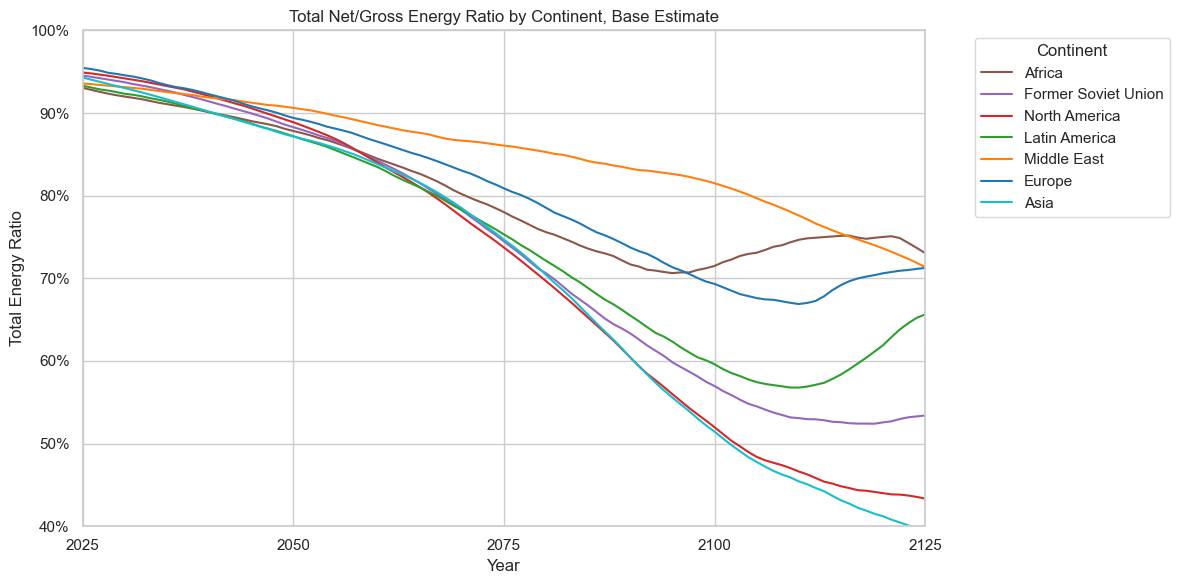

In [108]:
from matplotlib.ticker import FuncFormatter, MultipleLocator, LogLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color palette with distinct colors
palette = sns.color_palette("tab10", n_colors=len(con_base_d.columns[1:]))

# Convert to a DataFrame
# Plotting the line graph
plt.figure(figsize=(12, 6))

# Iterate through the columns and assign colors
for idx, column in enumerate(con_base_d.columns[1:]):
    if column[-12:] == "Energy Ratio":
        plt.plot(
            con_base_d["Year"],
            con_base_d[column],
            label=column.replace(" Total Energy Ratio", ""),
            color=palette[idx]  # Assign a unique color from the palette
        )

# Customize the axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.set_xlim(left=2025, right=2125)
ax.set_ylim(top=1, bottom=0.4)

formatter = FuncFormatter(lambda y, _: f"{int(y*100)}%")
ax.yaxis.set_major_formatter(formatter)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Total Energy Ratio")
plt.title("Total Net/Gross Energy Ratio by Continent, Base Estimate")
plt.legend(title="Continent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# Show and save the plot
plt.tight_layout()
plt.savefig('Outputs/TotalEnergyRatioByContinent.png')
plt.show()


C:\Users\kaife\AppData\Local\Temp\ipykernel_22068\3053156600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Quarter_Century"] = pd.cut(


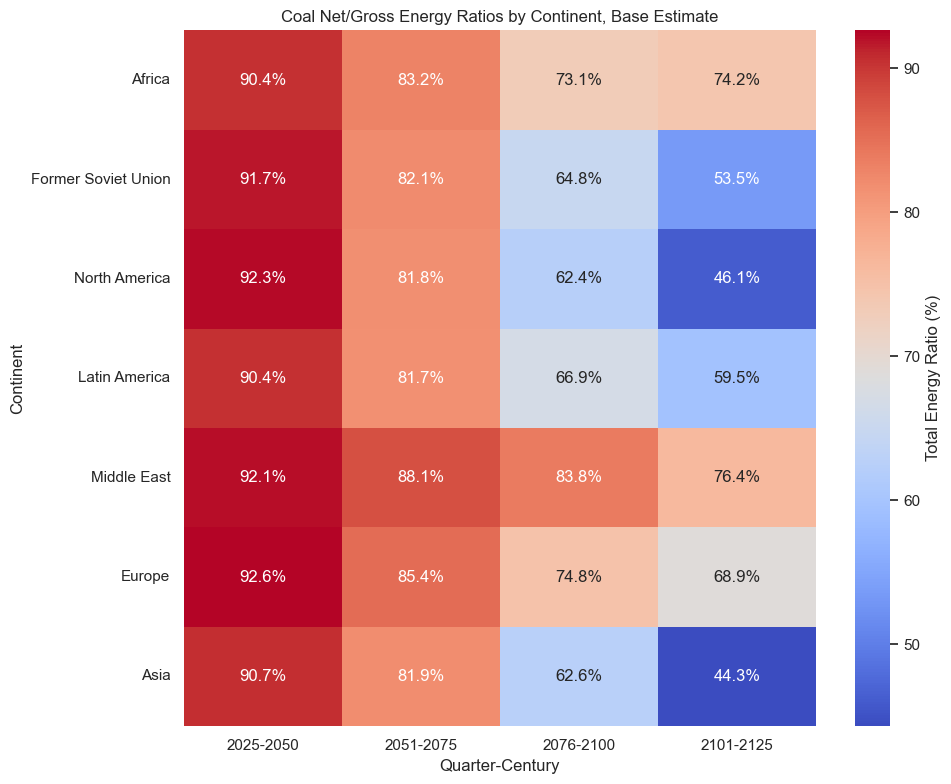

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for the range 2025 to 2125
filtered_data = con_base_d[(con_base_d["Year"] >= 2025) & (con_base_d["Year"] <= 2125)]

# Group data into 25-year intervals (quarter-centuries)
filtered_data["Quarter_Century"] = pd.cut(
    filtered_data["Year"], 
    bins=[2025, 2050, 2075, 2100, 2125],  # Define quarter-century bins
    labels=["2025-2050", "2051-2075", "2076-2100", "2101-2125"], 
    right=True
)

# Aggregate data by quarter-century
quarter_century_data = filtered_data.groupby("Quarter_Century").mean().filter(like="Energy Ratio").T

# Convert to percentages
quarter_century_data *= 100
quarter_century_data.index = quarter_century_data.index.str.replace(" Total Energy Ratio", "")


# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    quarter_century_data, 
    cmap="coolwarm", 
    annot=True,  # Display values
    fmt=".1f",   # Format numbers
    cbar_kws={"label": "Total Energy Ratio (%)"}
)

# Manually format annotations to include '%'
for text in plt.gca().texts:  # Loop through annotation texts
    text.set_text(f"{text.get_text()}%")

plt.xlabel("Quarter-Century")
plt.ylabel("Continent")
plt.title("Coal Net/Gross Energy Ratios by Continent, Base Estimate")
plt.tight_layout()
plt.savefig('Outputs/HeatmapEnergyRatioByContinent.png')
plt.show()


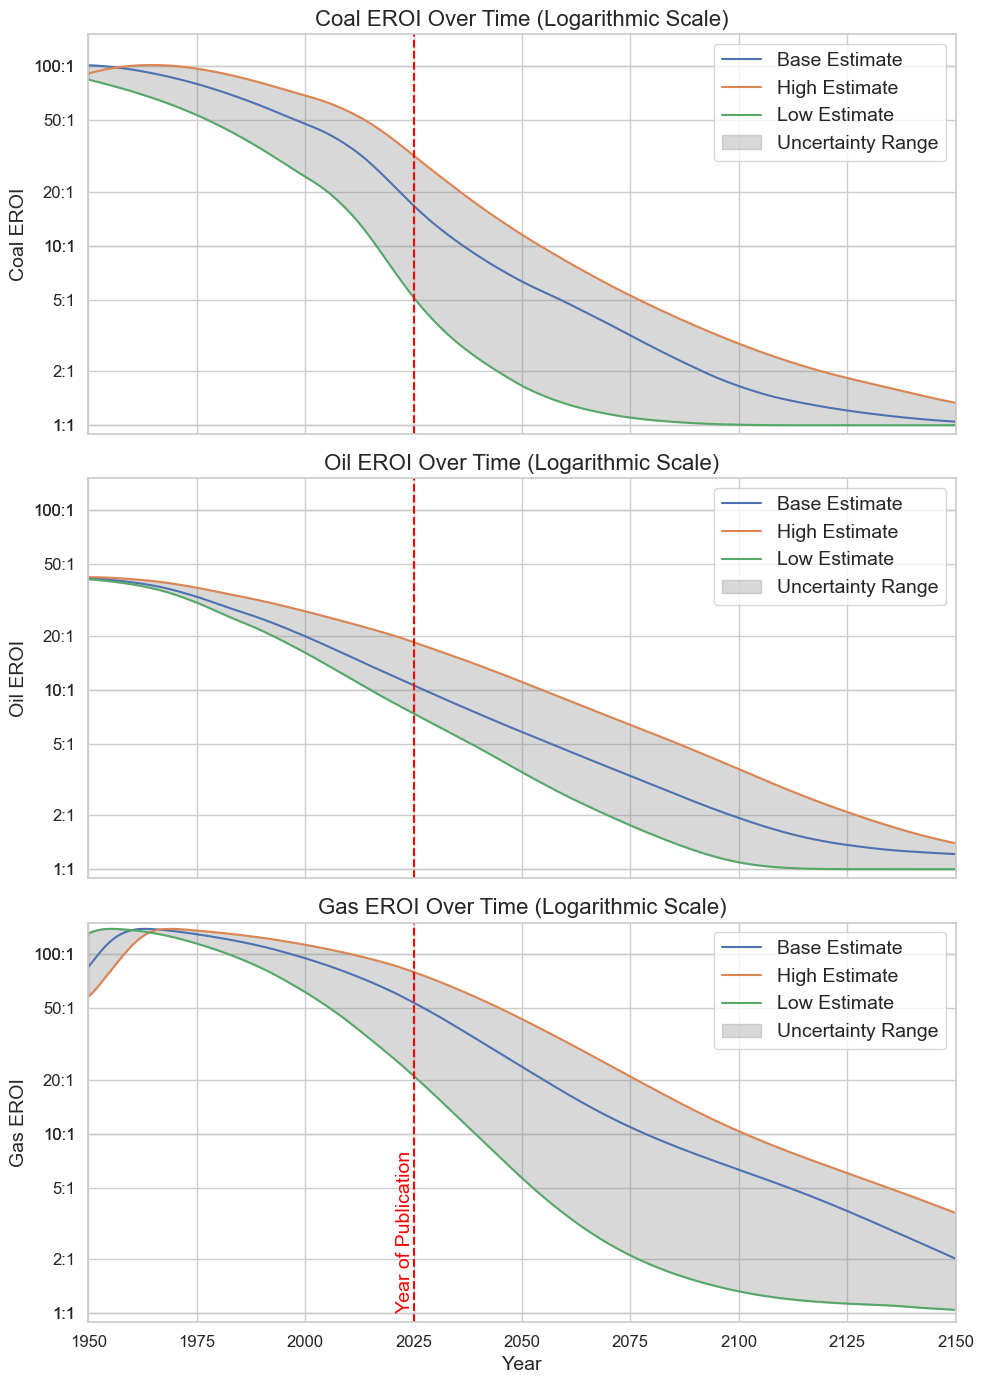

In [11]:
from matplotlib.ticker import FuncFormatter, MultipleLocator, LogLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style
sns.set(style="whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

# Coal EROI Plot
x_interp = np.linspace(1950, 2150, 500)
y_interp_coal_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Coal EROI'])
y_interp_coal_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Coal EROI'])
y_interp_coal_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Coal EROI'])

axes[0].set_yscale('log')
formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
axes[0].yaxis.set_major_formatter(formatter)

axes[0].xaxis.set_major_locator(MultipleLocator(25))
axes[0].set_ylim(top=150)
axes[0].margins(x=0)
axes[0].yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))
axes[0].tick_params(axis='both', which='major', labelsize=12)

sns.lineplot(ax=axes[0], x=x_interp, y=y_interp_coal_b, label="Base Estimate")
sns.lineplot(ax=axes[0], x=x_interp, y=y_interp_coal_h, label="High Estimate")
sns.lineplot(ax=axes[0], x=x_interp, y=y_interp_coal_l, label="Low Estimate")

y_lower = np.minimum.reduce([y_interp_coal_b, y_interp_coal_l, y_interp_coal_h])
y_upper = np.maximum.reduce([y_interp_coal_b, y_interp_coal_l, y_interp_coal_h])

axes[0].fill_between(x_interp, y_lower, y_upper, color='gray', alpha=0.3, label="Uncertainty Range")
axes[0].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[0].get_ylim()

axes[0].set_title("Coal EROI Over Time (Logarithmic Scale)", fontsize=16)
axes[0].set_ylabel("Coal EROI", fontsize=14)
axes[0].legend(fontsize=14)

# Oil EROI Plot
y_interp_oil_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Oil EROI'])
y_interp_oil_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Oil EROI'])
y_interp_oil_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Oil EROI'])

axes[1].set_yscale('log')
axes[1].yaxis.set_major_formatter(formatter)

axes[1].xaxis.set_major_locator(MultipleLocator(25))
axes[1].set_ylim(top=150)
axes[1].margins(x=0)
axes[1].yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))
axes[1].tick_params(axis='both', which='major', labelsize=12)

sns.lineplot(ax=axes[1], x=x_interp, y=y_interp_oil_b, label="Base Estimate")
sns.lineplot(ax=axes[1], x=x_interp, y=y_interp_oil_h, label="High Estimate")
sns.lineplot(ax=axes[1], x=x_interp, y=y_interp_oil_l, label="Low Estimate")

y_lower = np.minimum.reduce([y_interp_oil_b, y_interp_oil_l, y_interp_oil_h])
y_upper = np.maximum.reduce([y_interp_oil_b, y_interp_oil_l, y_interp_oil_h])

axes[1].fill_between(x_interp, y_lower, y_upper, color='gray', alpha=0.3, label="Uncertainty Range")
axes[1].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[1].get_ylim()

axes[1].set_title("Oil EROI Over Time (Logarithmic Scale)", fontsize=16)
axes[1].set_ylabel("Oil EROI", fontsize=14)
axes[1].legend(fontsize=14)

# Gas EROI Plot
y_interp_gas_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Gas EROI'])
y_interp_gas_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Gas EROI'])
y_interp_gas_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Gas EROI'])

axes[2].set_yscale('log')
axes[2].yaxis.set_major_formatter(formatter)

axes[2].xaxis.set_major_locator(MultipleLocator(25))
axes[2].set_ylim(top=150)
axes[2].margins(x=0)
axes[2].yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))
axes[2].tick_params(axis='both', which='major', labelsize=12)


sns.lineplot(ax=axes[2], x=x_interp, y=y_interp_gas_b, label="Base Estimate")
sns.lineplot(ax=axes[2], x=x_interp, y=y_interp_gas_h, label="High Estimate")
sns.lineplot(ax=axes[2], x=x_interp, y=y_interp_gas_l, label="Low Estimate")

y_lower = np.minimum.reduce([y_interp_gas_b, y_interp_gas_l, y_interp_gas_h])
y_upper = np.maximum.reduce([y_interp_gas_b, y_interp_gas_l, y_interp_gas_h])

axes[2].fill_between(x_interp, y_lower, y_upper, color='gray', alpha=0.3, label="Uncertainty Range")
axes[2].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[2].get_ylim()
axes[2].text(2025 - 2, 1, "Year of Publication", color='red', fontsize=14, rotation=90, va='bottom', ha='center')

axes[2].set_title("Gas EROI Over Time (Logarithmic Scale)", fontsize=16)
axes[2].set_xlabel("Year", fontsize=14)
axes[2].set_ylabel("Gas EROI", fontsize=14)
axes[2].legend(fontsize=14)

# Adjust layout and save
plt.tight_layout()
plt.savefig('Outputs/CombinedEROIOverTime.png')
plt.show()


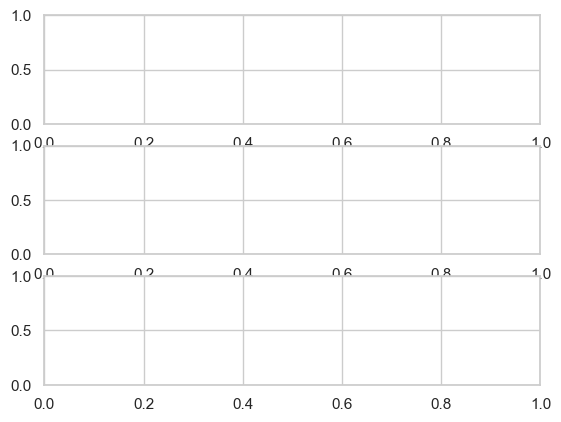

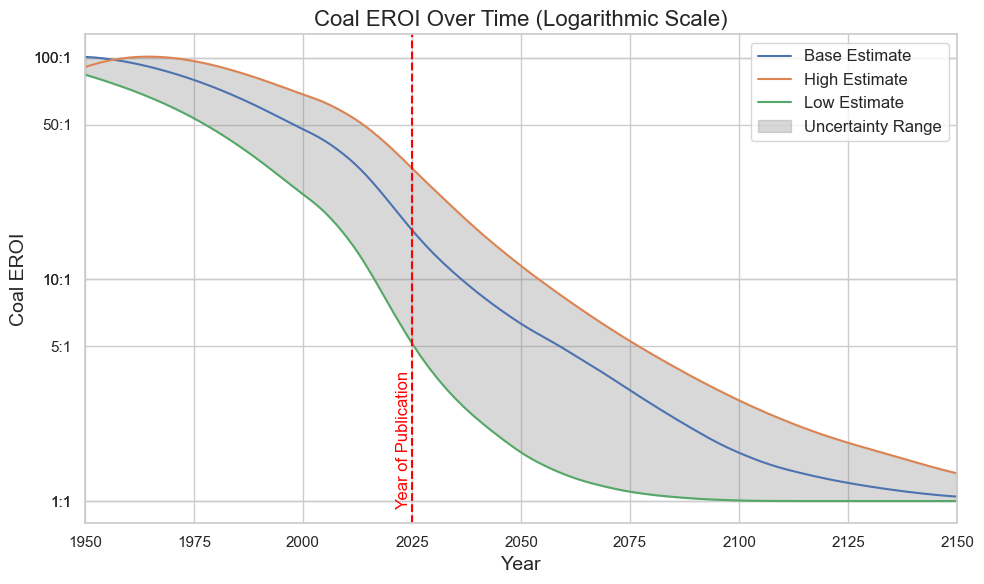

In [12]:
from matplotlib.ticker import FuncFormatter, MultipleLocator, LogLocator
fig, axs = plt.subplots(3)

# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1950, 2150, 500)
y_interp_coal_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Coal EROI'])
y_interp_coal_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Coal EROI'])
y_interp_coal_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Coal EROI'])
plt.yscale('log')

formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0)

# Double the ticks on the y-axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))

# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_coal_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_coal_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_coal_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_coal_b, y_interp_coal_l, y_interp_coal_h])
y_upper = np.maximum.reduce([y_interp_coal_b, y_interp_coal_l, y_interp_coal_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.001, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Coal EROI Over Time (Logarithmic Scale)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Coal EROI", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/CoalEROIOverTime.png')
plt.show()

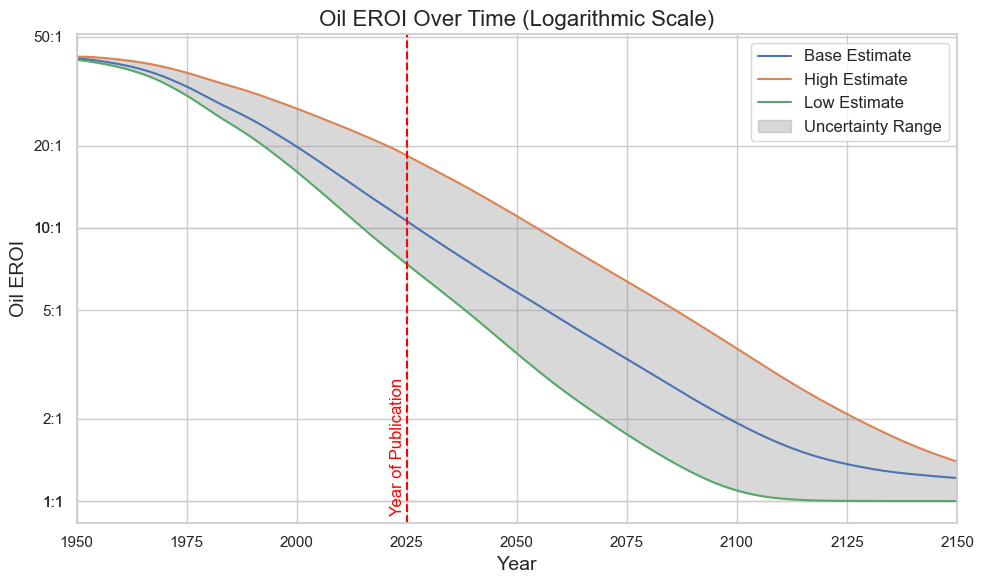

In [13]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1950, 2150, 500)
y_interp_Oil_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Oil EROI'])
y_interp_Oil_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Oil EROI'])
y_interp_Oil_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Oil EROI'])
plt.yscale('log')

formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0)

# Double the ticks on the y-axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 2, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_Oil_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_Oil_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_Oil_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_Oil_b, y_interp_Oil_l, y_interp_Oil_h])
y_upper = np.maximum.reduce([y_interp_Oil_b, y_interp_Oil_l, y_interp_Oil_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.001, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Oil EROI Over Time (Logarithmic Scale)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Oil EROI", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/OilEROIOverTime.png')
plt.show()

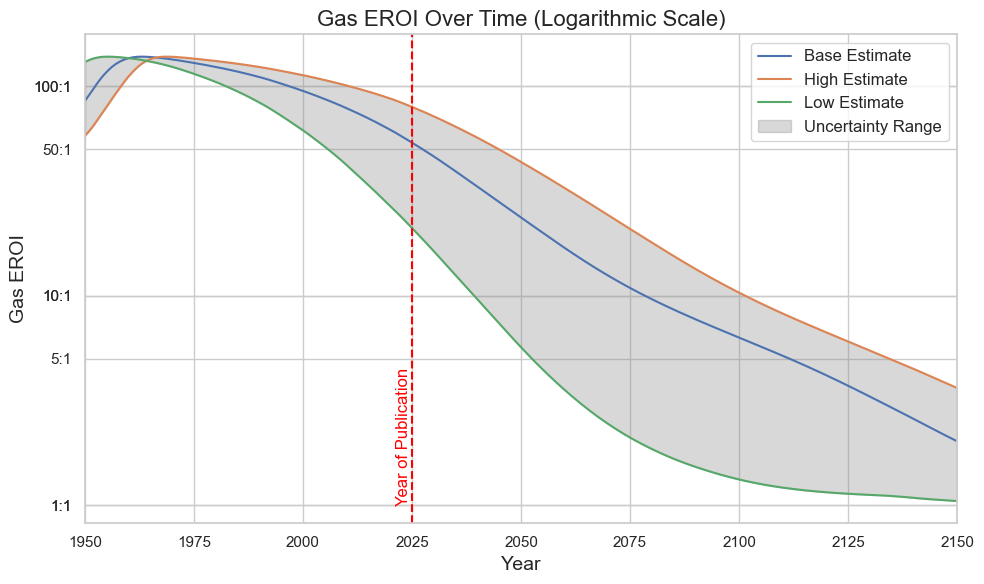

In [14]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1950, 2150, 500)
y_interp_Gas_b = np.interp(x_interp, base_d_EROI['Year'], base_d_EROI['Gas EROI'])
y_interp_Gas_h = np.interp(x_interp, high_d_EROI['Year'], high_d_EROI['Gas EROI'])
y_interp_Gas_l = np.interp(x_interp, low_d_EROI['Year'], low_d_EROI['Gas EROI'])
plt.yscale('log')

formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0)

# Double the ticks on the y-axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_Gas_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_Gas_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_Gas_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_Gas_b, y_interp_Gas_l, y_interp_Gas_h])
y_upper = np.maximum.reduce([y_interp_Gas_b, y_interp_Gas_l, y_interp_Gas_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.001, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Gas EROI Over Time (Logarithmic Scale)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Gas EROI", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GasEROIOverTime.png')
plt.show()

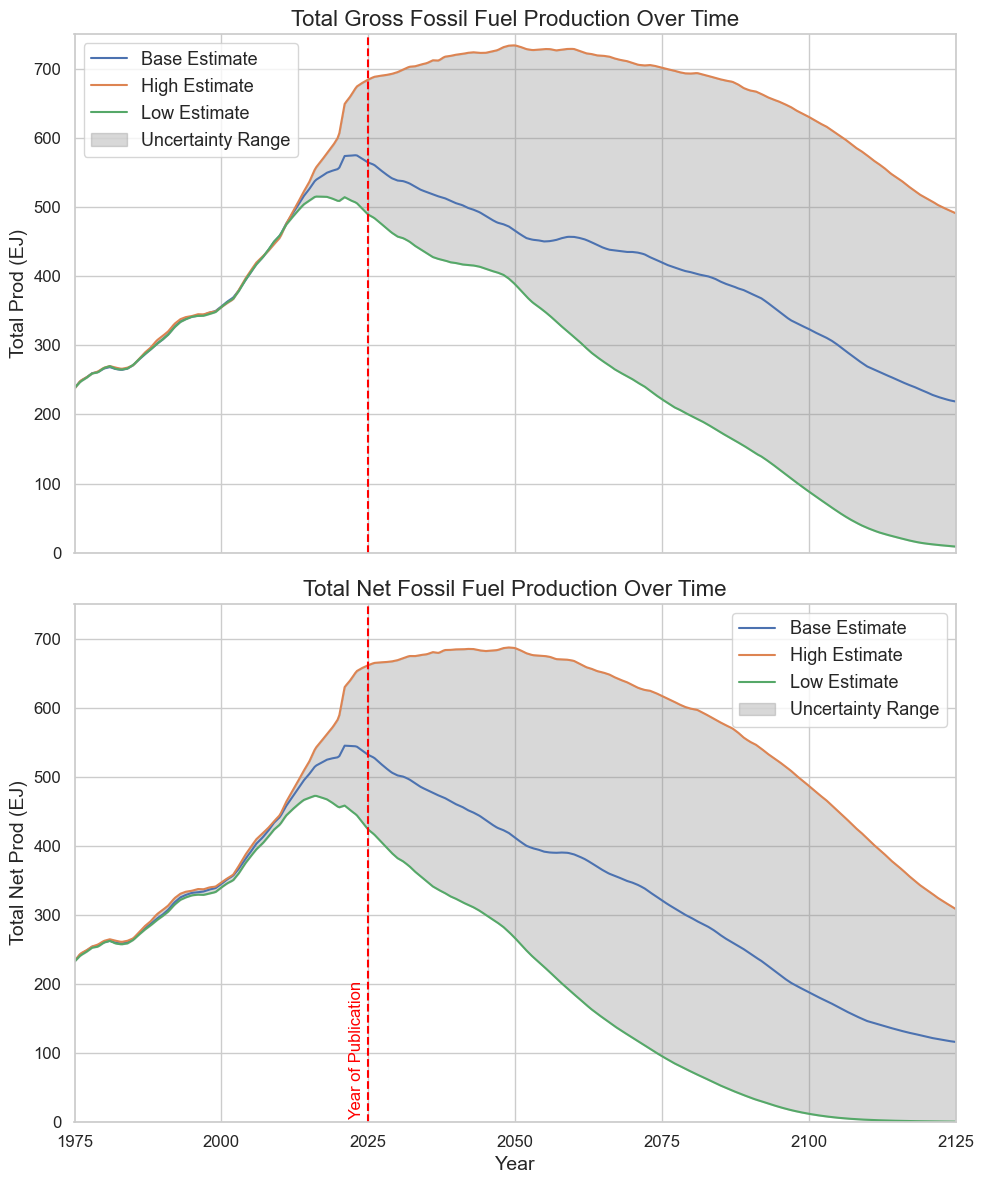

In [45]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Data interpolation range
x_interp = np.linspace(1975, 2125, 500)

# ---- Plot 1: Total Fossil Fuel Production ----
base_sum = base_d_prod["Gas Prod"] + base_d_prod["Oil Prod"] + base_d_prod["Coal Prod"]
high_sum = high_d_prod["Gas Prod"] + high_d_prod["Oil Prod"] + high_d_prod["Coal Prod"]
low_sum = low_d_prod["Gas Prod"] + low_d_prod["Oil Prod"] + low_d_prod["Coal Prod"]

y_interp_total_b = np.interp(x_interp, base_d_EROI['Year'], base_sum)
y_interp_total_h = np.interp(x_interp, high_d_EROI['Year'], high_sum)
y_interp_total_l = np.interp(x_interp, low_d_EROI['Year'], low_sum)

axes[0].plot(x_interp, y_interp_total_b, label="Base Estimate")
axes[0].plot(x_interp, y_interp_total_h, label="High Estimate")
axes[0].plot(x_interp, y_interp_total_l, label="Low Estimate")

# Add uncertainty shading
y_lower = np.minimum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])
y_upper = np.maximum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])
axes[0].fill_between(x_interp, y_lower, y_upper, color='gray', alpha=0.3, label="Uncertainty Range")

# Add vertical line for 2025
axes[0].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[0].get_ylim()
axes[0].set_ylim(top=750, bottom = 0)

# Customize the first plot
axes[0].set_title("Total Gross Fossil Fuel Production Over Time", fontsize=16)
axes[0].set_ylabel("Total Prod (EJ)", fontsize=14)
axes[0].legend(fontsize=13)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# ---- Plot 2: Total Net Fossil Fuel Production ----
base_sum_net = base_d_prod_net_en["Gas Prod"] + base_d_prod_net_en["Oil Prod"] + base_d_prod_net_en["Coal Prod"]
high_sum_net = high_d_prod_net_en["Gas Prod"] + high_d_prod_net_en["Oil Prod"] + high_d_prod_net_en["Coal Prod"]
low_sum_net = low_d_prod_net_en["Gas Prod"] + low_d_prod_net_en["Oil Prod"] + low_d_prod_net_en["Coal Prod"]

y_interp_total_b_net = np.interp(x_interp, base_d_EROI['Year'], base_sum_net)
y_interp_total_h_net = np.interp(x_interp, high_d_EROI['Year'], high_sum_net)
y_interp_total_l_net = np.interp(x_interp, low_d_EROI['Year'], low_sum_net)

axes[1].plot(x_interp, y_interp_total_b_net, label="Base Estimate")
axes[1].plot(x_interp, y_interp_total_h_net, label="High Estimate")
axes[1].plot(x_interp, y_interp_total_l_net, label="Low Estimate")

# Add uncertainty shading
y_lower_net = np.minimum.reduce([y_interp_total_b_net, y_interp_total_l_net, y_interp_total_h_net])
y_upper_net = np.maximum.reduce([y_interp_total_b_net, y_interp_total_l_net, y_interp_total_h_net])
axes[1].fill_between(x_interp, y_lower_net, y_upper_net, color='gray', alpha=0.3, label="Uncertainty Range")

# Add vertical line for 2025
axes[1].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[1].get_ylim()
axes[1].text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')
axes[1].set_ylim(top=750, bottom = 0)

# Customize the second plot
axes[1].set_title("Total Net Fossil Fuel Production Over Time", fontsize=16)
axes[1].set_xlabel("Year", fontsize=14)
axes[1].set_ylabel("Total Net Prod (EJ)", fontsize=14)
axes[1].legend(fontsize=13)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Configure shared x-axis
axes[1].xaxis.set_major_locator(MultipleLocator(25))
axes[1].margins(x=0)

# Adjust layout and save
plt.tight_layout()
plt.savefig('Outputs/TotalAndNetProdOverTime.png')
plt.show()

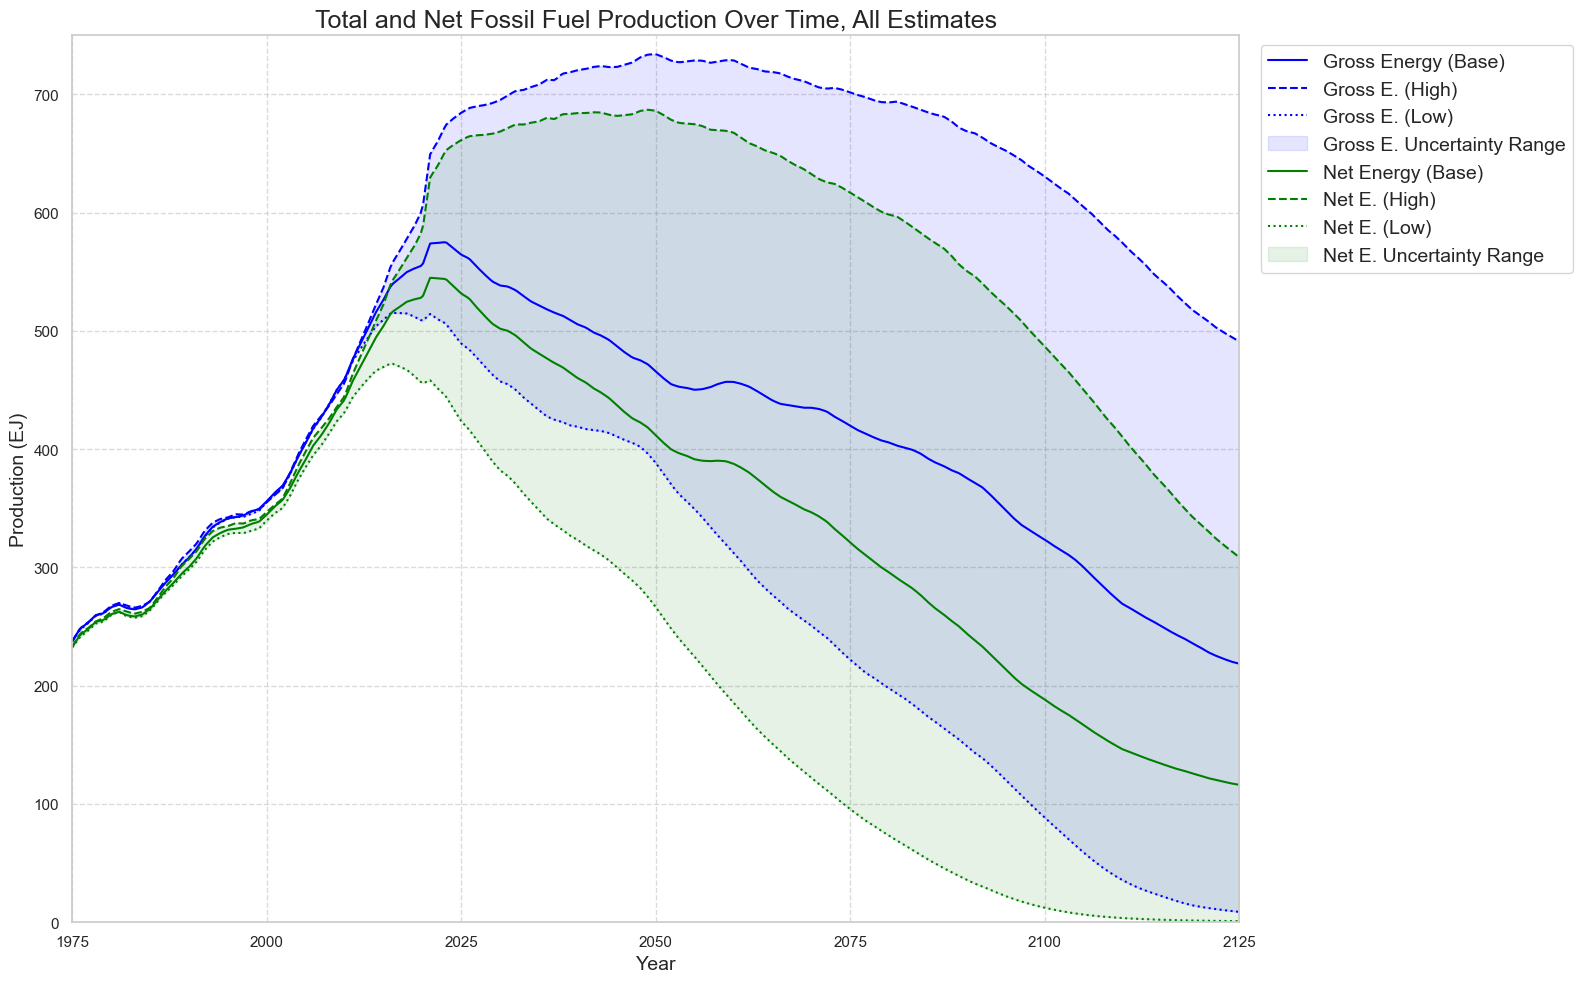

In [136]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(16, 10))

# Data interpolation range
x_interp = np.linspace(1975, 2125, 500)

# ---- Total Fossil Fuel Production ----
base_sum = base_d_prod["Gas Prod"] + base_d_prod["Oil Prod"] + base_d_prod["Coal Prod"]
high_sum = high_d_prod["Gas Prod"] + high_d_prod["Oil Prod"] + high_d_prod["Coal Prod"]
low_sum = low_d_prod["Gas Prod"] + low_d_prod["Oil Prod"] + low_d_prod["Coal Prod"]

y_interp_total_b = np.interp(x_interp, base_d_EROI['Year'], base_sum)
y_interp_total_h = np.interp(x_interp, high_d_EROI['Year'], high_sum)
y_interp_total_l = np.interp(x_interp, low_d_EROI['Year'], low_sum)

# ---- Total Net Fossil Fuel Production ----
base_sum_net = base_d_prod_net_en["Gas Prod"] + base_d_prod_net_en["Oil Prod"] + base_d_prod_net_en["Coal Prod"]
high_sum_net = high_d_prod_net_en["Gas Prod"] + high_d_prod_net_en["Oil Prod"] + high_d_prod_net_en["Coal Prod"]
low_sum_net = low_d_prod_net_en["Gas Prod"] + low_d_prod_net_en["Oil Prod"] + low_d_prod_net_en["Coal Prod"]

y_interp_total_b_net = np.interp(x_interp, base_d_EROI['Year'], base_sum_net)
y_interp_total_h_net = np.interp(x_interp, high_d_EROI['Year'], high_sum_net)
y_interp_total_l_net = np.interp(x_interp, low_d_EROI['Year'], low_sum_net)

# Plot Total Production
plt.plot(x_interp, y_interp_total_b, label="Gross Energy (Base)", color='blue', linestyle='-')
plt.plot(x_interp, y_interp_total_h, label="Gross E. (High)", color='blue', linestyle='--')
plt.plot(x_interp, y_interp_total_l, label="Gross E. (Low)", color='blue', linestyle=':')

# Add Uncertainty Shading for Total Production
y_lower = np.minimum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])
y_upper = np.maximum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])
plt.fill_between(x_interp, y_lower, y_upper, color='blue', alpha=0.1, label="Gross E. Uncertainty Range")

# Plot Total Net Production
plt.plot(x_interp, y_interp_total_b_net, label="Net Energy (Base)", color='green', linestyle='-')
plt.plot(x_interp, y_interp_total_h_net, label="Net E. (High)", color='green', linestyle='--')
plt.plot(x_interp, y_interp_total_l_net, label="Net E. (Low)", color='green', linestyle=':')

# Add Uncertainty Shading for Net Production
y_lower_net = np.minimum.reduce([y_interp_total_b_net, y_interp_total_l_net, y_interp_total_h_net])
y_upper_net = np.maximum.reduce([y_interp_total_b_net, y_interp_total_l_net, y_interp_total_h_net])
plt.fill_between(x_interp, y_lower_net, y_upper_net, color='green', alpha=0.1, label="Net E. Uncertainty Range")

# # Add a vertical line for 2025
# plt.axvline(x=2025, color='red', linestyle='--')
# y_min, y_max = plt.gca().get_ylim()
# plt.text(2025 - 2, y_min - (y_min - y_max) * 0.075, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0)
ax.set_ylim(top=750, bottom = 0)

# Customize the plot
plt.title("Total and Net Fossil Fuel Production Over Time, All Estimates", fontsize=18)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Production (EJ)", fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1), loc="upper left")
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and Show
plt.savefig('Outputs/TotalAndNetProdCombined.png')
plt.show()


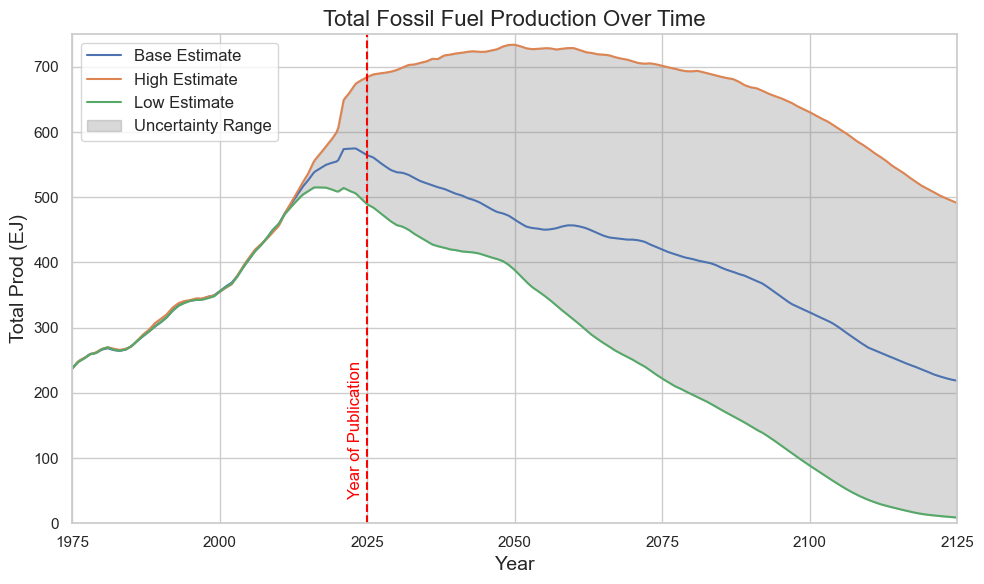

In [34]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

base_sum = base_d_prod["Gas Prod"] + base_d_prod["Oil Prod"] + base_d_prod["Coal Prod"]
high_sum = high_d_prod["Gas Prod"] + high_d_prod["Oil Prod"] + high_d_prod["Coal Prod"]
low_sum = low_d_prod["Gas Prod"] + low_d_prod["Oil Prod"] + low_d_prod["Coal Prod"]

# Interpolation for smoothness
x_interp = np.linspace(1975, 2125, 500)
y_interp_total_b = np.interp(x_interp, base_d_EROI['Year'], base_sum)
y_interp_total_h = np.interp(x_interp, high_d_EROI['Year'], high_sum)
y_interp_total_l = np.interp(x_interp, low_d_EROI['Year'], low_sum)

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0)


# # Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_total_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_total_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_total_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])
y_upper = np.maximum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Total Gross Fossil Fuel Production Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Prod (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/TotalProdOverTime.png')
plt.show()

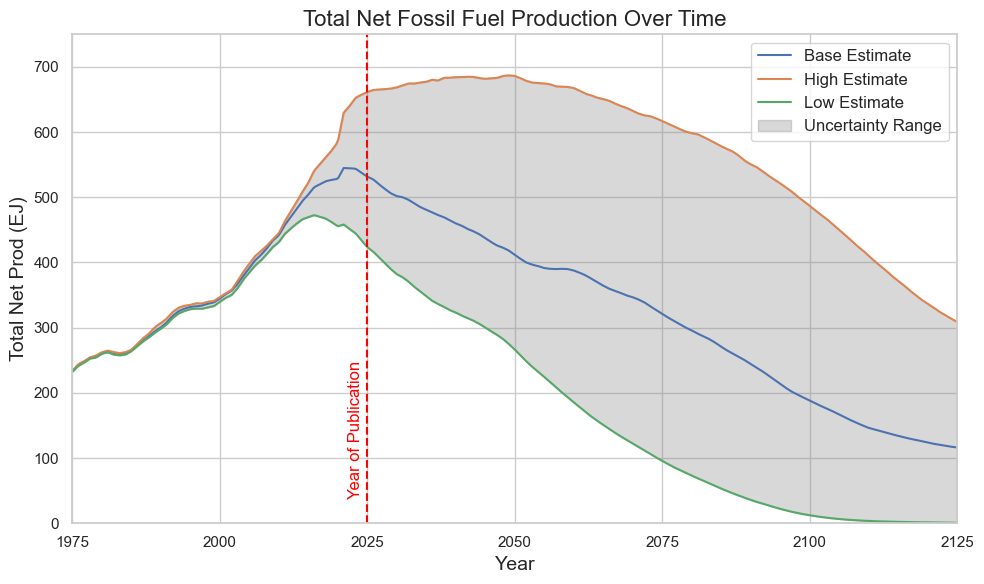

In [35]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

base_sum = base_d_prod_net_en["Gas Prod"] + base_d_prod_net_en["Oil Prod"] + base_d_prod_net_en["Coal Prod"]
high_sum = high_d_prod_net_en["Gas Prod"] + high_d_prod_net_en["Oil Prod"] + high_d_prod_net_en["Coal Prod"]
low_sum = low_d_prod_net_en["Gas Prod"] + low_d_prod_net_en["Oil Prod"] + low_d_prod_net_en["Coal Prod"]
# Interpolation for smoothness
x_interp = np.linspace(1975, 2125, 500)
y_interp_total_b = np.interp(x_interp, base_d_EROI['Year'], base_sum)
y_interp_total_h = np.interp(x_interp, high_d_EROI['Year'], high_sum)
y_interp_total_l = np.interp(x_interp, low_d_EROI['Year'], low_sum)

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0)

# # Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_total_b, label="Base Estimate")
sns.lineplot(x=x_interp, y=y_interp_total_h, label="High Estimate")
sns.lineplot(x=x_interp, y=y_interp_total_l, label="Low Estimate")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])
y_upper = np.maximum.reduce([y_interp_total_b, y_interp_total_l, y_interp_total_h])

# Add a single uncertainty shading region
plt.fill_between(
    x_interp, y_lower, y_upper, 
    color='gray', alpha=0.3, label="Uncertainty Range"
)

# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Total Net Fossil Fuel Production Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Net Prod (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/TotalNetProdOverTime.png')
plt.show()

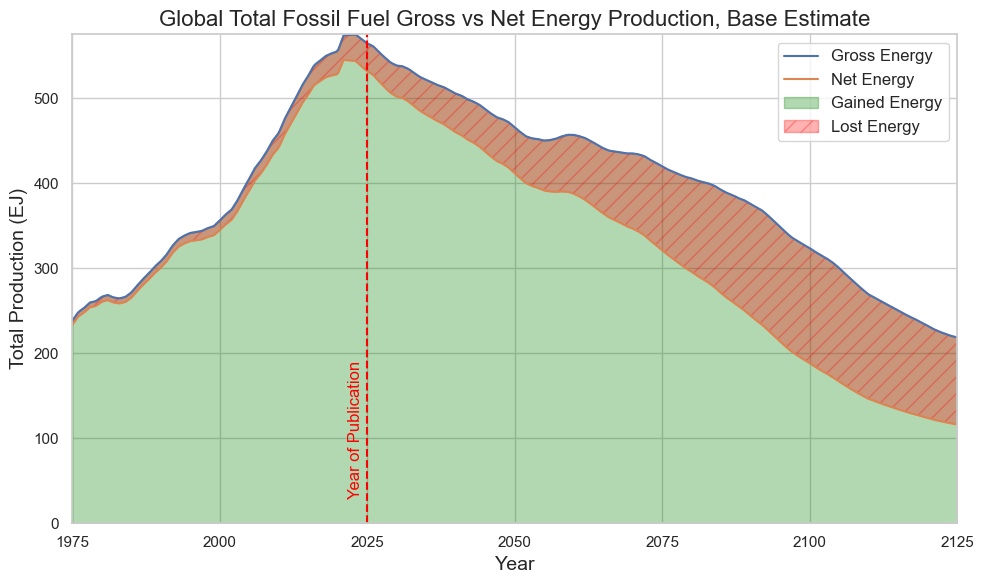

In [17]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

net_sum = base_d_prod_net_en["Gas Prod"] + base_d_prod_net_en["Oil Prod"] + base_d_prod_net_en["Coal Prod"]
gross_sum = base_d_prod["Gas Prod"] + base_d_prod["Oil Prod"] + base_d_prod["Coal Prod"]

# Interpolation for smoothness
x_interp = np.linspace(1975, 2125, 500)
y_interp_gross = np.interp(x_interp, base_d_prod['Year'], gross_sum)
y_interp_net = np.interp(x_interp, base_d_prod_net_en['Year'], net_sum)

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")


# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Global Total Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalTotalProductionGrossVsNetBase.png')
plt.show()

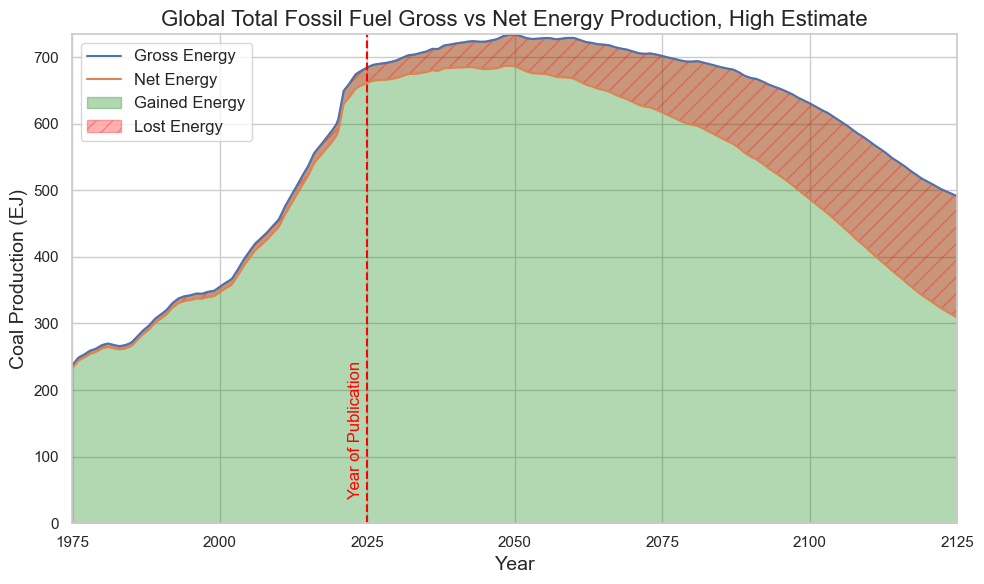

In [18]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

net_sum = high_d_prod_net_en["Gas Prod"] + high_d_prod_net_en["Oil Prod"] + high_d_prod_net_en["Coal Prod"]
gross_sum = high_d_prod["Gas Prod"] + high_d_prod["Oil Prod"] + high_d_prod["Coal Prod"]

# Interpolation for smoothness
x_interp = np.linspace(1975, 2125, 500)
y_interp_gross = np.interp(x_interp, high_d_prod['Year'], gross_sum)
y_interp_net = np.interp(x_interp, high_d_prod_net_en['Year'], net_sum)

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")


# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Global Total Fossil Fuel Gross vs Net Energy Production, High Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Coal Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalTotalProductionGrossVsNetHigh.png')
plt.show()

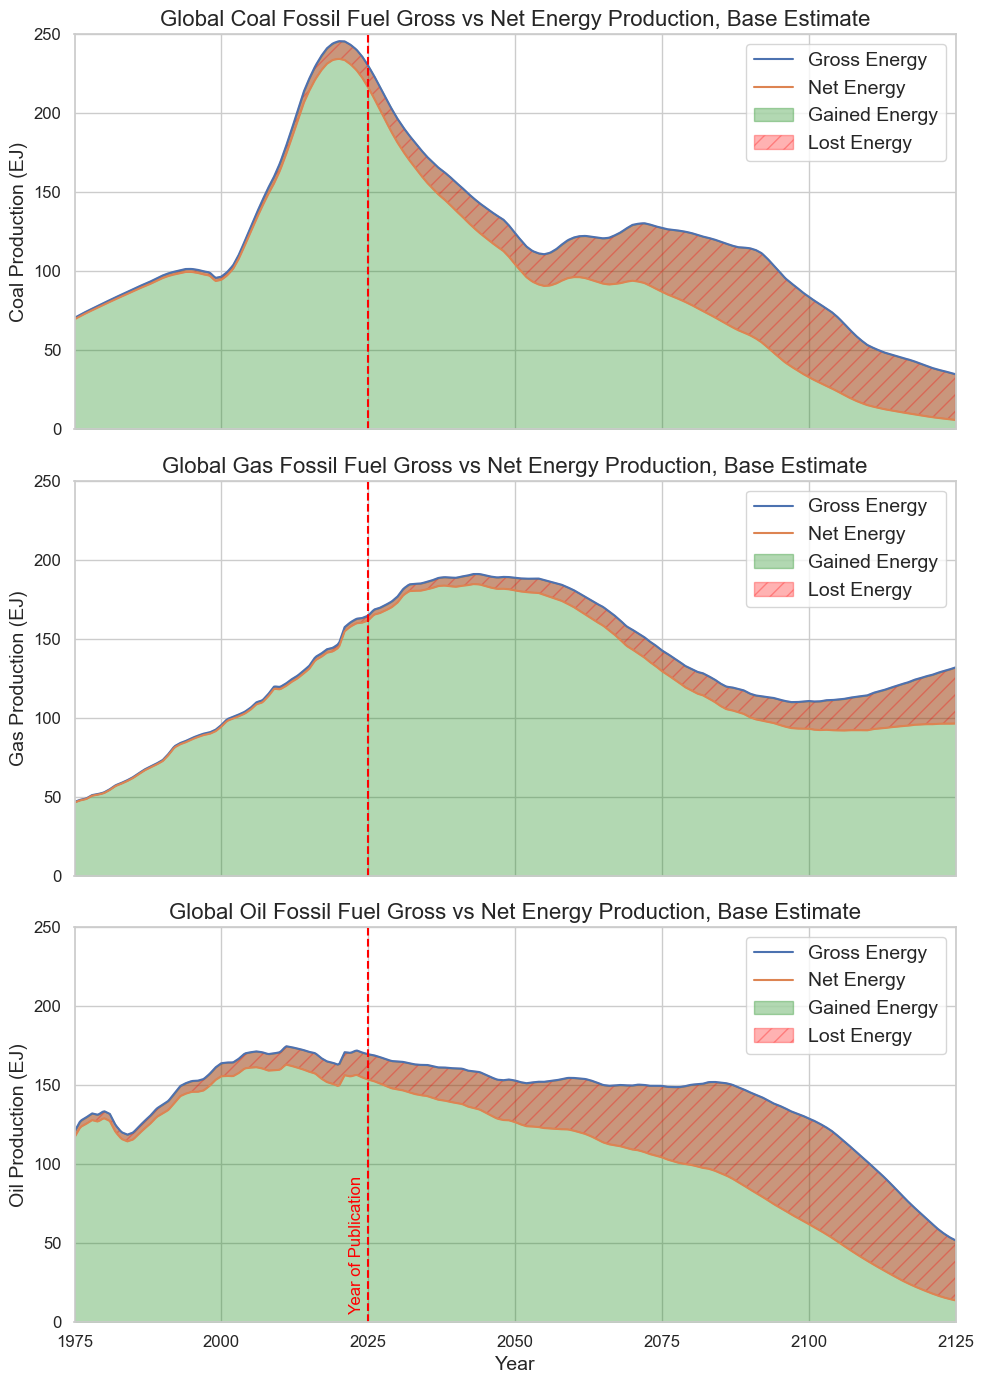

In [33]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

# Data interpolation range
x_interp = np.linspace(1975, 2125, 500)

# Plot for Coal
y_interp_gross_coal = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Coal Prod'])
y_interp_net_coal = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Coal Prod'])

axes[0].plot(x_interp, y_interp_gross_coal, label="Gross Energy")
axes[0].plot(x_interp, y_interp_net_coal, label="Net Energy")

axes[0].fill_between(x_interp, y_interp_gross_coal, color='green', alpha=0.3, label="Gained Energy")
axes[0].fill_between(x_interp, y_interp_net_coal, y_interp_gross_coal, color='red', hatch="//", alpha=0.3, label="Lost Energy")

axes[0].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[0].get_ylim()
axes[0].set_ylim(top=250, bottom=0)
axes[0].margins(x=0,y=0)


axes[0].set_title("Global Coal Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
axes[0].set_ylabel("Coal Production (EJ)", fontsize=14)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot for Gas
y_interp_gross_gas = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Gas Prod'])
y_interp_net_gas = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Gas Prod'])

axes[1].plot(x_interp, y_interp_gross_gas, label="Gross Energy")
axes[1].plot(x_interp, y_interp_net_gas, label="Net Energy")

axes[1].fill_between(x_interp, y_interp_gross_gas, color='green', alpha=0.3, label="Gained Energy")
axes[1].fill_between(x_interp, y_interp_net_gas, y_interp_gross_gas, color='red', hatch="//", alpha=0.3, label="Lost Energy")

axes[1].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[1].get_ylim()
axes[1].set_ylim(top=250, bottom=0)
axes[1].margins(x=0,y=0)

axes[1].set_title("Global Gas Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
axes[1].set_ylabel("Gas Production (EJ)", fontsize=14)
axes[1].legend(fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Plot for Oil
y_interp_gross_oil = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Oil Prod'])
y_interp_net_oil = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Oil Prod'])

axes[2].plot(x_interp, y_interp_gross_oil, label="Gross Energy")
axes[2].plot(x_interp, y_interp_net_oil, label="Net Energy")

axes[2].fill_between(x_interp, y_interp_gross_oil, color='green', alpha=0.3, label="Gained Energy")
axes[2].fill_between(x_interp, y_interp_net_oil, y_interp_gross_oil, color='red', hatch="//", alpha=0.3, label="Lost Energy")

axes[2].axvline(x=2025, color='red', linestyle='--')
y_min, y_max = axes[2].get_ylim()
axes[2].text(2025 - 2, 5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')
axes[2].set_ylim(top=250, bottom=0)
axes[2].margins(x=0,y=0)

axes[2].set_title("Global Oil Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
axes[2].set_xlabel("Year", fontsize=14)
axes[2].set_ylabel("Oil Production (EJ)", fontsize=14)
axes[2].legend(fontsize=14)
axes[2].tick_params(axis='both', which='major', labelsize=12)

# Configure shared x-axis
axes[2].xaxis.set_major_locator(MultipleLocator(25))
axes[2].margins(x=0)

# Adjust layout and save
plt.tight_layout()
plt.savefig('Outputs/ProductionGrossVsNetCombined.png')
plt.show()

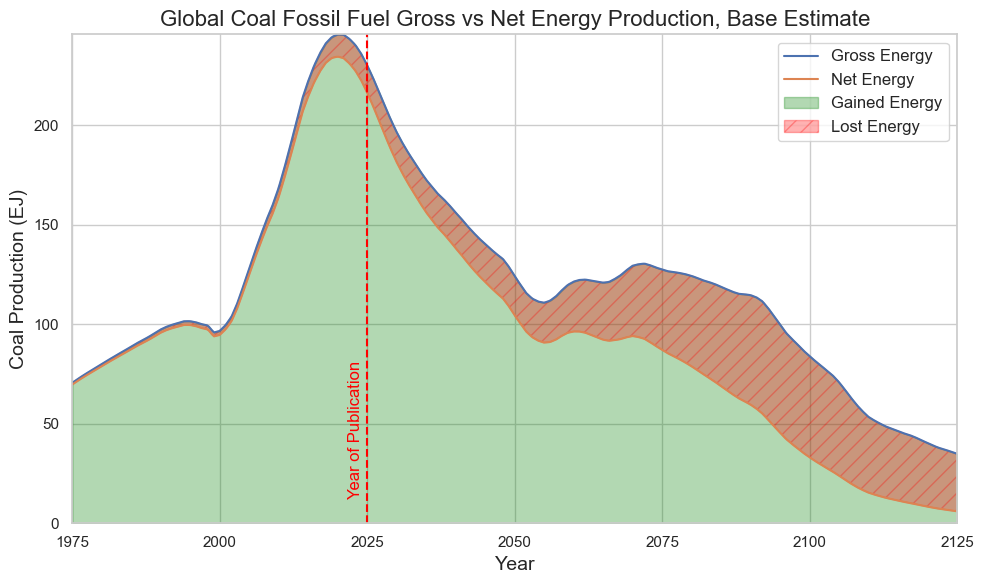

In [20]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1975, 2125, 500)
y_interp_gross = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Coal Prod'])
y_interp_net = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Coal Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")


# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Global Coal Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Coal Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalCoalProductionGrossVsNet.png')
plt.show()

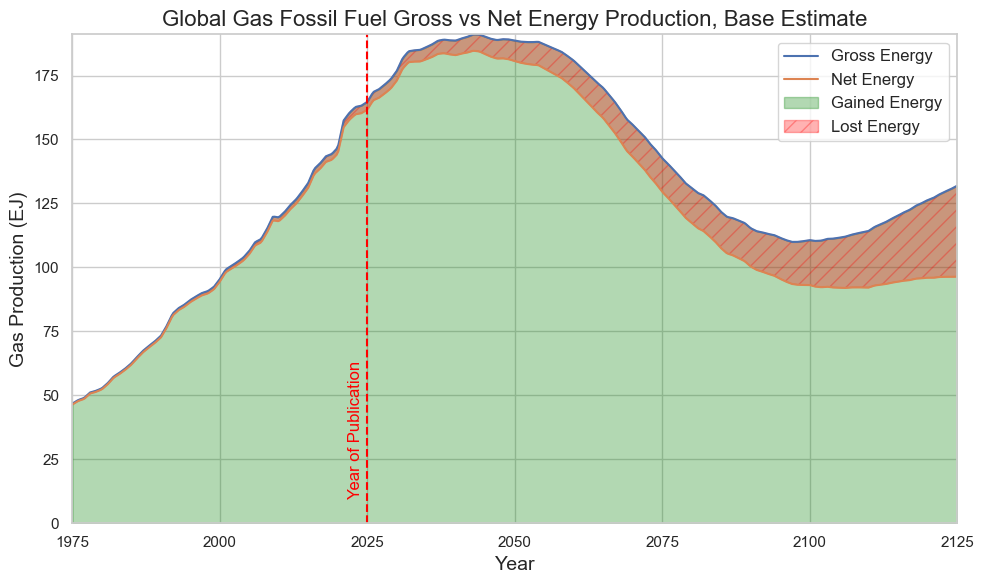

In [21]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1975, 2125, 500)
y_interp_gross = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Gas Prod'])
y_interp_net = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Gas Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")


# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# # Add a vertical line for 2024
# plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
# plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Global Gas Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Gas Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalGasProductionGrossVsNet.png')
plt.show()

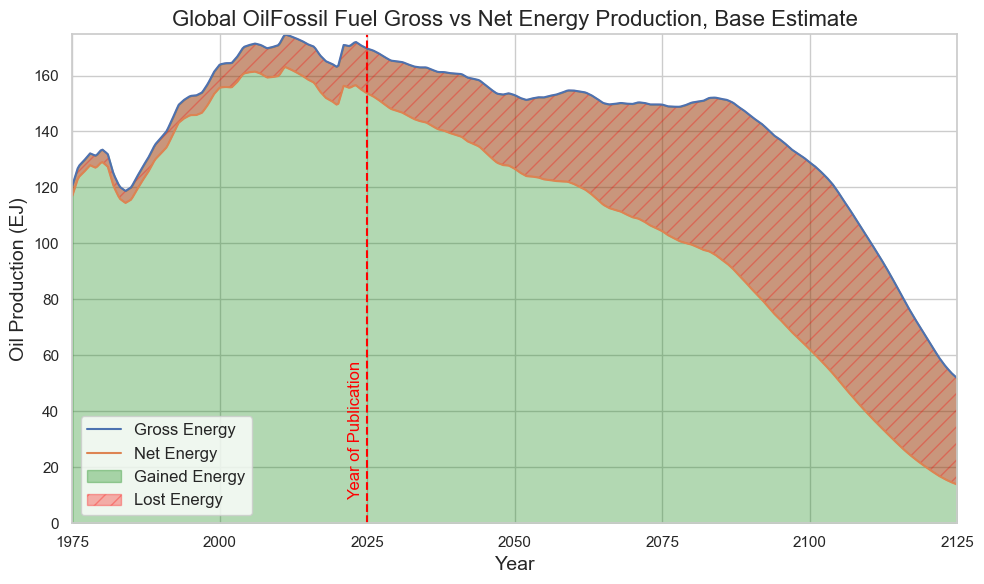

In [22]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(1975, 2125, 500)
y_interp_gross = np.interp(x_interp, base_d_prod['Year'], base_d_prod['Oil Prod'])
y_interp_net = np.interp(x_interp, base_d_prod_net_en['Year'], base_d_prod_net_en['Oil Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")

# Add a vertical line for 2025
y_min, y_max = plt.gca().get_ylim()
plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
plt.text(2025 - 2, y_min - (y_min - y_max) * 0.05, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')


# Customize the plot
plt.title("Global Oil Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Oil Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/GlobalOilProductionGrossVsNet.png')
plt.show()

In [23]:
# display(cleaned_base_df)
australia_base_df = cleaned_base_df[cleaned_base_df['country'] == 'Australia']
australia_base_d_prod = gersdemo_prod_results(australia_base_df, clean=False)
australia_base_d_net_en = net_energy_results(australia_base_df, base_d_EROI)
australia_base_d_prod_net_en = gersdemo_prod_results(australia_base_d_net_en, clean=False)
# display(australia_base_d_prod)
australia_base_d_prod.to_csv('Outputs/Tables/AustraliaBaseProdGross.csv')
australia_base_d_prod_net_en.to_csv('Outputs/Tables/AustraliaBaseProdNet.csv')



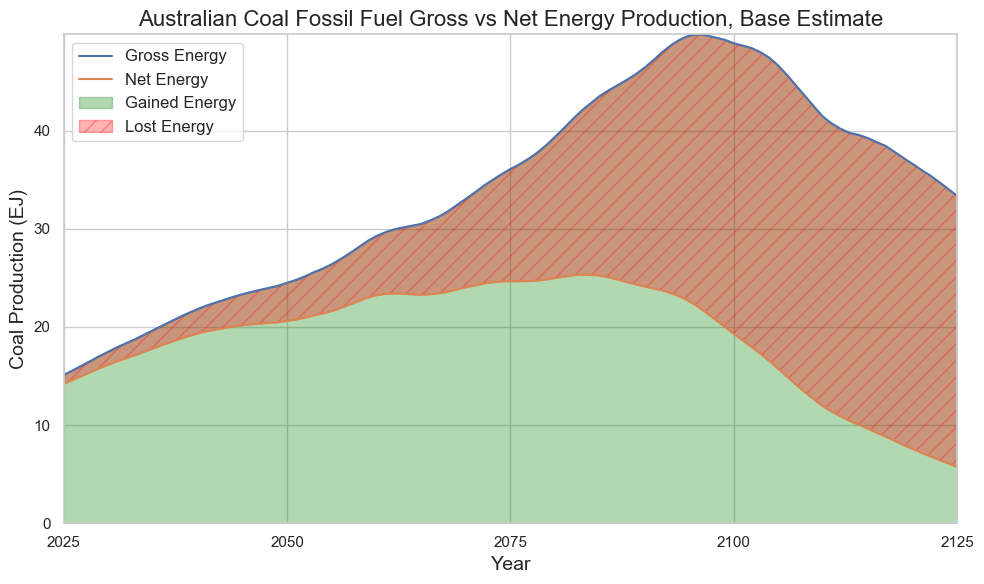

In [24]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(2025, 2125, 500)
y_interp_gross = np.interp(x_interp, australia_base_d_prod['Year'], australia_base_d_prod['Coal Prod'])
y_interp_net = np.interp(x_interp, australia_base_d_prod_net_en['Year'], australia_base_d_prod_net_en['Coal Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")

# # Add a vertical line for 2024
# plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
# plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Australian Coal Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Coal Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/AustralianCoalProductionGrossVsNet.png')
plt.show()

In [25]:
plt.show()
# display(cleaned_base_df)
us_base_df = cleaned_base_df[cleaned_base_df['country'] == 'USA']
display(us_base_df)
us_base_d_prod = gersdemo_prod_results(us_base_df, clean=False)
us_base_d_net_en = net_energy_results(us_base_df, base_d_EROI)
us_base_d_prod_net_en = gersdemo_prod_results(us_base_d_net_en, clean=False)

,continent,country,region,subregion,mineral,submineral,unit,Model/Data,1710.0,1711.0,...,2396.0,2397.0,2398.0,2399.0,2400.0,2401.0,2402.0,2403,2404,2405
624,North_America,USA,Alabama,All,Coal,Bituminous,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
625,North_America,USA,Alabama,All,Gas,CBM,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
626,North_America,USA,Alabama,All,Gas,Conventional,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
627,North_America,USA,Alabama,All,Oil,Conventional,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
628,North_America,USA,Alabama,All,Oil,Natural_Bitumen,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,North_America,USA,Wyoming,All,Gas,Conventional,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
787,North_America,USA,Wyoming,All,Oil,Conventional,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
788,North_America,USA,Wyoming,All,Oil,Natural_Bitumen,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
789,North_America,USA,Wyoming,Greater_Green_River,Oil,Kerogen,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


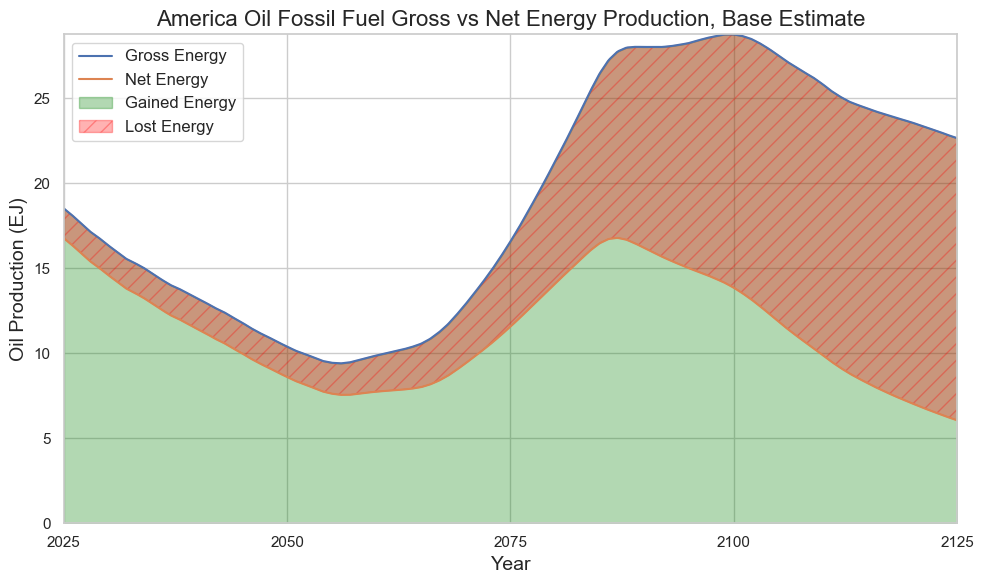

In [26]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(2025, 2125, 500)
y_interp_gross = np.interp(x_interp, us_base_d_prod['Year'], us_base_d_prod['Oil Prod'])
y_interp_net = np.interp(x_interp, us_base_d_prod_net_en['Year'], us_base_d_prod_net_en['Oil Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")


# # Add a vertical line for 2024
# plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
# plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("America Oil Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Oil Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/AmericanOilProductionGrossVsNet.png')
plt.show()

In [27]:
plt.show()
# display(cleaned_base_df)
can_base_df = cleaned_base_df[cleaned_base_df['country'] == 'Canada']
display(can_base_df)
can_base_d_prod = gersdemo_prod_results(can_base_df, clean=False)
can_base_d_net_en = net_energy_results(can_base_df, base_d_EROI)
can_base_d_prod_net_en = gersdemo_prod_results(can_base_d_net_en, clean=False)

,continent,country,region,subregion,mineral,submineral,unit,Model/Data,1710.0,1711.0,...,2396.0,2397.0,2398.0,2399.0,2400.0,2401.0,2402.0,2403,2404,2405
568,North_America,Canada,Alberta,All,Coal,Bituminous,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
569,North_America,Canada,Alberta,All,Coal,Sub-bituminous,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
570,North_America,Canada,Alberta,All,Gas,Conventional,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
571,North_America,Canada,Alberta,All,Oil,Conventional,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
572,North_America,Canada,Alberta,All,Oil,Extra_Heavy,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
573,North_America,Canada,Alberta,All,Oil,Tight,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
574,North_America,Canada,Alberta,Colorado,Gas,Shale,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
575,North_America,Canada,Alberta,Deep_Basin,Gas,Tight,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
576,North_America,Canada,Alberta,Duvernay,Gas,Shale,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
577,North_America,Canada,Alberta,Horseshoe_Canyon,Gas,CBM,EJ/y,Model,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


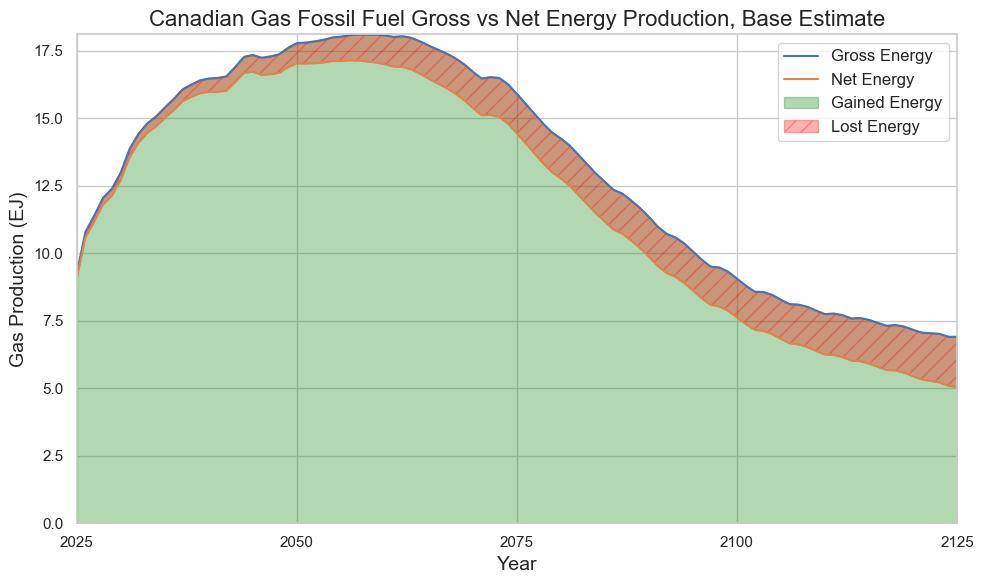

In [28]:
# Create a smooth line plot using interpolation
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Interpolation for smoothness
x_interp = np.linspace(2025, 2125, 500)
y_interp_gross = np.interp(x_interp, can_base_d_prod['Year'], can_base_d_prod['Gas Prod'])
y_interp_net = np.interp(x_interp, can_base_d_prod_net_en['Year'], can_base_d_prod_net_en['Gas Prod'])

# formatter = FuncFormatter(lambda y, _: f"{int(y)}:1" if y >= 1 else "")
# plt.gca().yaxis.set_major_formatter(formatter)

# Double the ticks on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(25))  # Adjust interval for x-axis ticks
ax.margins(x=0,y=0)

# Double the ticks on the y-axis
# ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=[1, 5, 10], numticks=2))


# Plot the smooth line
sns.lineplot(x=x_interp, y=y_interp_gross, label="Gross Energy")
sns.lineplot(x=x_interp, y=y_interp_net, label="Net Energy")

# Calculate the upper and lower bounds for the uncertainty region
y_lower = np.minimum.reduce([y_interp_gross, y_interp_net])
y_upper = np.maximum.reduce([y_interp_gross, y_interp_net])

# Add a single uncertainty shading region
plt.fill_between(x_interp, y_interp_gross, color='green', alpha=0.3, label="Gained Energy")
plt.fill_between(x_interp, y_interp_net, y_interp_gross, color='red', hatch="//",alpha=0.3, label="Lost Energy")


# # Add a vertical line for 2024
# plt.axvline(x=2025, color='red', linestyle='--')  # Add vertical line
# plt.text(2025 - 2, plt.gca().get_ylim()[0] * 1.5, "Year of Publication", color='red', fontsize=12, rotation=90, va='bottom', ha='center')

# Customize the plot
plt.title("Canadian Gas Fossil Fuel Gross vs Net Energy Production, Base Estimate", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Gas Production (EJ)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Display the plot
plt.savefig('Outputs/CanadianGasProductionGrossVsNet.png')
plt.show()